In [1]:
from data import sample_latents
from vis import visualize_latents, visualize_slots_and_output, visualize_output_grid
from models import InvertibleMLP, ParallelSlots, LinearComposition, CompositionalFunction

In [2]:
D = [2, 4, 3]
M = [16, 16, 16]

z = sample_latents(D, "face_grid", n_samples=1000, grid_size=11, dims=(2, 7))

phi = ParallelSlots([InvertibleMLP(d_in, d_out, d_hidden=10) for d_in, d_out in zip(D, M)])
C = LinearComposition()
f = CompositionalFunction(C, phi)

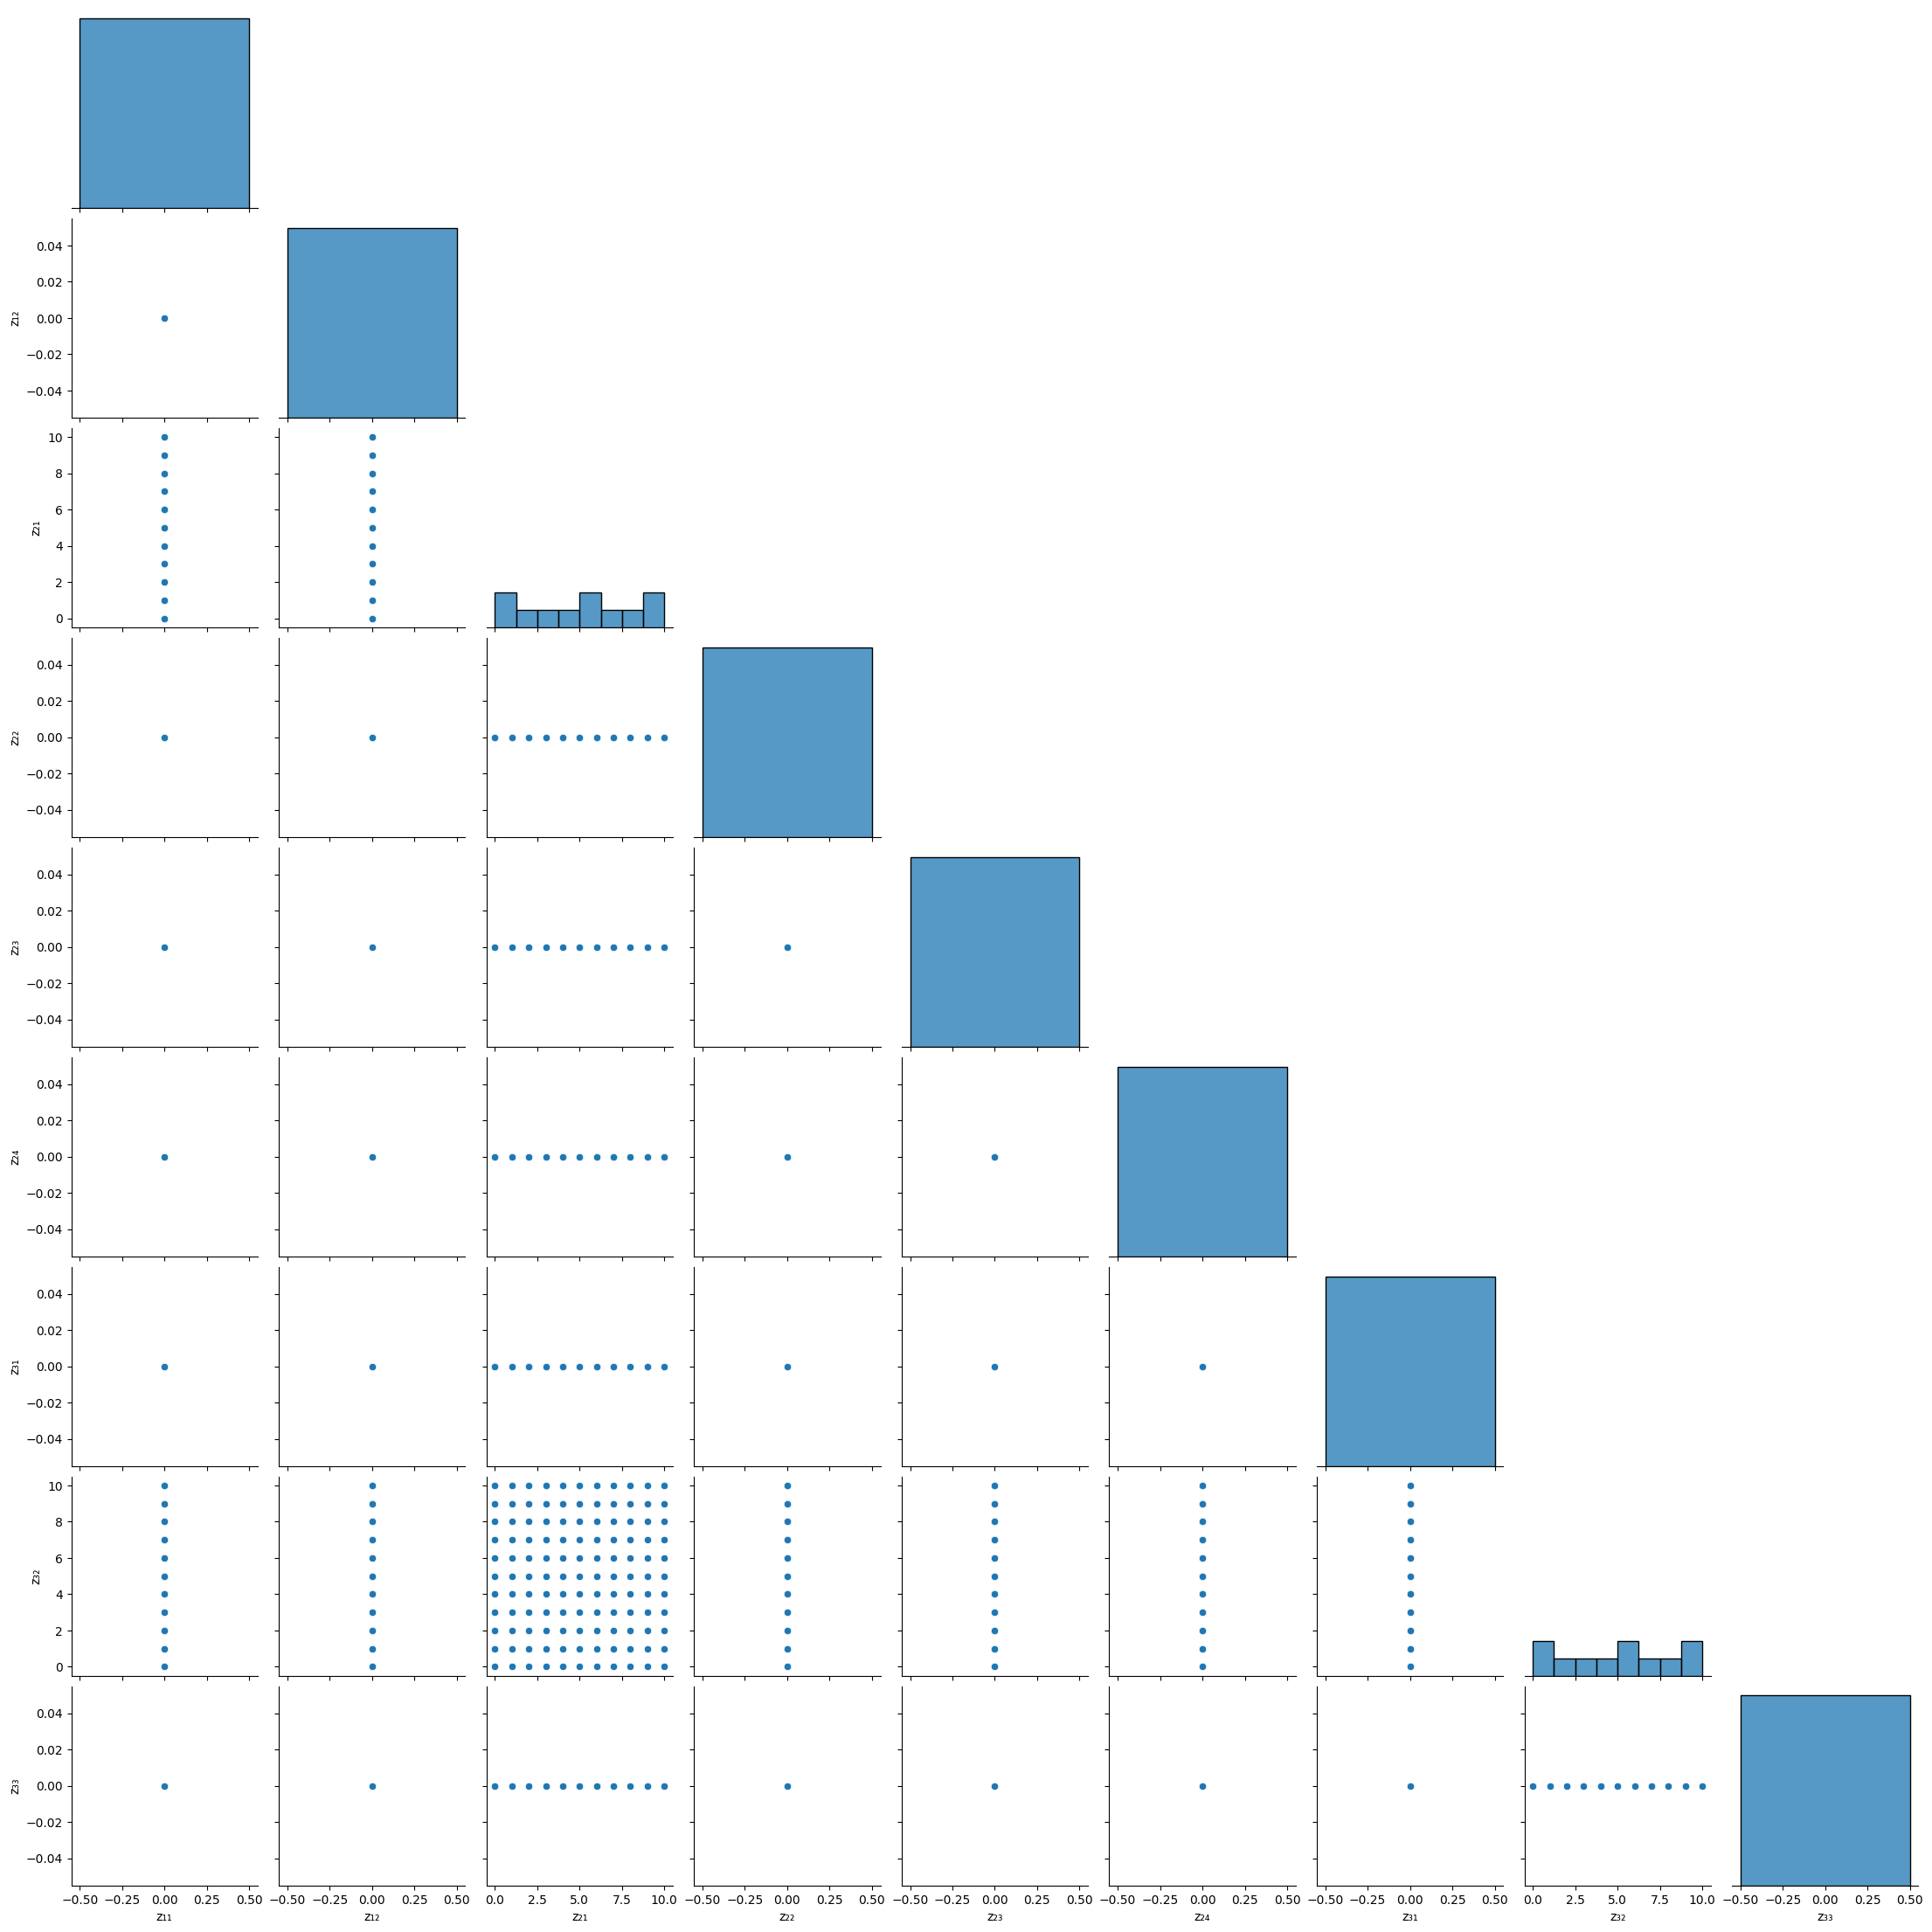

In [3]:
visualize_latents(z, D)

In [ ]:
visualize_slots_and_output(*f(z[:10], return_slot_outputs=True))

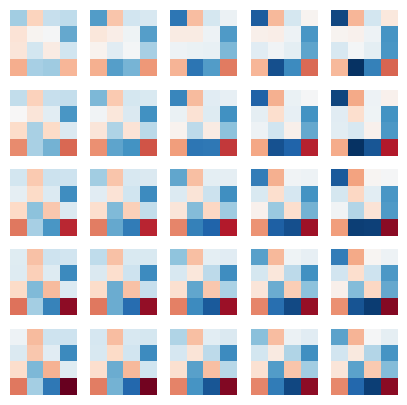

In [10]:
visualize_output_grid(f, 5, (0, 1), plot_size=1)